# 0. Setting Up The Env

## 0.1 Import Packages

In [28]:
from pathlib import Path

In [29]:
from joblib import Parallel, delayed
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA

In [30]:
import pandas as pd
import numpy as np

from tqdm import tqdm 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")


In [31]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

## 0.2 Utilities

In [32]:
class KMeansModelBuilder:
    def __init__(self, data: pd.DataFrame, random_state: int = 99):
        """
        Initialize with a pandas DataFrame.
        Args:
            data (pd.DataFrame): Processed input data
            random_state (int): Random seed for reproducibility
        """
        self.data = data
        self.random_state = random_state
        self.scaled_data = None
        self.kmeans = None
        self.optimal_k = None
        self.wcss_scores = []
        self.silhouette_scores = []
        self.wcss_drop = []


    def scale_data(self):
        """Standardize data using StandardScaler."""
        scaler = StandardScaler()
        self.scaled_data = scaler.fit_transform(self.data)
        print("Data successfully scaled using StandardScaler.")

    def evaluate_k_values(self, max_k = 10):
        """
        Evaluate different K values to find the optimal one using
        WCSS (Elbow method) and Silhouette Score.
        Also computes WCSS drop (ΔWCSS) between consecutive K.
        
        Args:
            max_k (int): Maximum number of clusters to evaluate (default = 10)
        """
        k_range = range(2, max_k+1)
        if self.scaled_data is None:
            raise ValueError("Data must be scaled before evaluation. Call scale_data().")

        self.wcss_scores = []
        self.silhouette_scores = []

        for k in k_range:
            kmeans = KMeans(n_clusters=k, random_state=self.random_state, init='k-means++',n_init=10)
            kmeans.fit(self.scaled_data)
            wcss = kmeans.inertia_
            sil_score = silhouette_score(self.scaled_data, kmeans.labels_)

            self.wcss_scores.append(wcss)
            self.silhouette_scores.append(sil_score)

            print(f"K={k}: WCSS={wcss:.2f}, Silhouette Score={sil_score:.4f}")

        # Compute WCSS drop (difference between consecutive WCSS values)
        self.wcss_drop = [self.wcss_scores[i-1] - self.wcss_scores[i] for i in range(1, len(self.wcss_scores))]

        # Determine best K based on the maximum silhouette score
        optimal_k = k_range[np.argmax(self.silhouette_scores)]
        print(f"\n Optimal K based on silhouette score: {optimal_k}")

        # Plot results
        self._plot_metrics(k_range)

    def _plot_metrics(self, k_range):
        """Private method to plot Elbow Curve and Silhouette Scores."""
        fig, ax = plt.subplots(1, 3, figsize=(18, 5))
        
        # Plot Elbow Curve
        ax[0].plot(k_range, self.wcss_scores, marker='o', color='blue')
        ax[0].set_title("Elbow Method (WCSS)")
        ax[0].set_xlabel("Number of Clusters (K)")
        ax[0].set_ylabel("WCSS")

        # Plot WCSS Drop (ΔWCSS)
        drop_k = list(k_range)[1:]  # since drop starts from K=3 (difference from previous)
        ax[1].plot(drop_k, self.wcss_drop, marker='o', color='orange')
        ax[1].set_title("WCSS Drop Between Consecutive K")
        ax[1].set_xlabel("Number of Clusters (K)")
        ax[1].set_ylabel("ΔWCSS (Previous - Current)")


        # Plot Silhouette Scores
        ax[2].plot(k_range, self.silhouette_scores, marker='o', color='red')
        ax[2].set_title("Silhouette Scores for K values")
        ax[2].set_xlabel("Number of Clusters (K)")
        ax[2].set_ylabel("Silhouette Score")

        plt.tight_layout()
        plt.show()


    def plot_elbow_silhouette_tradeoff(self, max_k):
        """
        Plot a combined Elbow + Silhouette chart to visualize the trade-off.
        WCSS is scaled (min-max normalization) for better comparison.
        """
        k_range = range(2, max_k + 1)
        if not self.wcss_scores or not self.silhouette_scores:
            raise ValueError("Run evaluate_k_values() first to compute WCSS and silhouette scores.")

        # Normalize WCSS for comparison
        wcss_scaled = (np.array(self.wcss_scores) - np.min(self.wcss_scores)) / (
            np.max(self.wcss_scores) - np.min(self.wcss_scores)
        )

        fig, ax1 = plt.subplots(figsize=(18, 5))

        # Plot WCSS (inverted because lower is better)
        ax1.plot(k_range, 1 - wcss_scaled, color='blue', marker='o', label='Normalized WCSS')
        ax1.set_xlabel('Number of Clusters (K)')
        ax1.set_ylabel('Normalized WCSS', color='blue')
        ax1.tick_params(axis='y', labelcolor='blue')

        # Plot Silhouette Score on secondary axis
        ax2 = ax1.twinx()
        ax2.plot(k_range, self.silhouette_scores, color='red', marker='o', label='Silhouette Score')
        ax2.set_ylabel('Silhouette Score', color='red')
        ax2.tick_params(axis='y', labelcolor='red')

        # Combine legends
        lines_1, labels_1 = ax1.get_legend_handles_labels()
        lines_2, labels_2 = ax2.get_legend_handles_labels()
        ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='best')

        plt.title("Elbow + Silhouette Trade-off Chart")
        plt.tight_layout()
        plt.show()


    def build_final_model(self, k):
        """Fit KMeans using the optimal number of clusters."""
        self.optimal_k = k

        self.kmeans = KMeans(
            n_clusters=self.optimal_k, 
            random_state=self.random_state,
            init='k-means++',
            n_init=10
        )
        self.kmeans.fit(self.scaled_data)
        labels = self.kmeans.labels_

        sil_score = silhouette_score(self.scaled_data, labels)
        print(f"Final KMeans model built with K={self.optimal_k}")
        print(f"Final Silhouette Score: {sil_score:.4f}")

        return labels

In [33]:
def drop_highly_correlated(X: pd.DataFrame, y: pd.Series, threshold: float = 0.65):
    # Absolute correlation among X columns
    corr = X.corr().abs()

    # Correlation of each feature with y
    corr_with_y = X.apply(lambda col: col.corr(y)).abs()

    to_drop = set()
    cols = X.columns

    # Traverse only upper triangle (excluding diagonal)
    for i in range(len(cols)):
        for j in range(i + 1, len(cols)):
            col1, col2 = cols[i], cols[j]
            val = corr.loc[col1, col2]

            if val > threshold:
                # Compare their correlation with y
                corr1, corr2 = corr_with_y[col1], corr_with_y[col2]
                if corr1 >= corr2:
                    drop_col = col2
                else:
                    drop_col = col1

                # Skip if already dropped
                if drop_col not in to_drop:
                    print(f"{col1} ↔ {col2} | corr={val:.3f} | drop={drop_col}")
                    to_drop.add(drop_col)

    print(f"\nColumns to drop ({len(to_drop)}): {sorted(to_drop)}")
    X_reduced = X.drop(columns=list(to_drop))
    return X_reduced, list(to_drop)

In [34]:
def calculate_vif_for_column(X, i):
    """Compute VIF for a single column (for joblib parallelism)."""
    try:
        return variance_inflation_factor(X.values, i)
    except Exception:
        return np.nan  # in case of perfect multicollinearity

def drop_high_vif_features(X: pd.DataFrame, threshold: float = 6.5, n_jobs: int = -1):
    """
    Iteratively drops features with VIF above the threshold.
    Uses joblib to parallelize VIF computation.
    """
    X_curr = X.copy()
    iteration = 1

    while True:
        # Compute VIFs in parallel
        vifs = Parallel(n_jobs=n_jobs)(
            delayed(calculate_vif_for_column)(X_curr, i)
            for i in range(X_curr.shape[1])
        )
        vif_df = pd.DataFrame({'feature': X_curr.columns, 'VIF': vifs})

        max_vif = vif_df['VIF'].max()
        max_col = vif_df.loc[vif_df['VIF'].idxmax(), 'feature']

        print(f"\nIteration {iteration}:")
        # print(vif_df.sort_values('VIF', ascending=False).reset_index(drop=True))

        if max_vif <= threshold:
            print(f"\n All VIFs ≤ {threshold}. Stopping.")
            break

        # Drop the feature with highest VIF
        print(f"Dropping '{max_col}' (VIF = {max_vif:.2f})")
        X_curr = X_curr.drop(columns=[max_col])
        iteration += 1

    return X_curr, vif_df

## 0.3 Constants

In [35]:
project_root = Path.cwd().parent
project_root

WindowsPath('d:/01 Work/06-Segmentations')

In [36]:
capped_file_path = f"{project_root}/data/processed/capped.csv"
target_file_path = f"{project_root}/data/processed/target.csv"
capped_file_path, target_file_path

('d:\\01 Work\\06-Segmentations/data/processed/capped.csv',
 'd:\\01 Work\\06-Segmentations/data/processed/target.csv')

# 1. The Data

In [37]:
data_X_df = pd.read_csv(capped_file_path)
print(data_X_df.shape)
data_X_df.head()

(4521, 33)


,age,default,balance,housing,loan,day,duration,campaign,pdays,previous,...,marital_married,marital_single,education_primary,education_secondary,education_tertiary,contact_cellular,contact_unknown,poutcome_failure,poutcome_other,poutcome_unknown
0,30,0,1787.0,0,0,19,79,1,-1,0,...,1,0,1,0,0,1,0,0,0,1
1,33,0,4789.0,1,1,11,220,1,339,4,...,1,0,0,1,0,1,0,1,0,0
2,35,0,1350.0,1,0,16,185,1,330,1,...,0,1,0,0,1,1,0,1,0,0
3,30,0,1476.0,1,1,3,199,4,-1,0,...,1,0,0,0,1,0,1,0,0,1
4,59,0,0.0,1,0,5,226,1,-1,0,...,1,0,0,1,0,0,1,0,0,1


In [38]:
data_y_df = pd.read_csv(target_file_path)
print(data_y_df.shape)
data_y_df.head()

(4521, 1)


,y
0,0
1,0
2,0
3,0
4,0


In [39]:
data_X_df.columns

Index(['age', 'default', 'balance', 'housing', 'loan', 'day', 'duration',
       'campaign', 'pdays', 'previous', 'sin_month', 'cos_month', 'job_admin.',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'marital_married',
       'marital_single', 'education_primary', 'education_secondary',
       'education_tertiary', 'contact_cellular', 'contact_unknown',
       'poutcome_failure', 'poutcome_other', 'poutcome_unknown'],
      dtype='object')

In [40]:
data_X_df.dtypes

age                      int64
default                  int64
balance                float64
housing                  int64
loan                     int64
day                      int64
duration                 int64
campaign                 int64
pdays                    int64
previous                 int64
sin_month              float64
cos_month              float64
job_admin.               int64
job_blue-collar          int64
job_entrepreneur         int64
job_housemaid            int64
job_management           int64
job_retired              int64
job_self-employed        int64
job_services             int64
job_student              int64
job_technician           int64
job_unemployed           int64
marital_married          int64
marital_single           int64
education_primary        int64
education_secondary      int64
education_tertiary       int64
contact_cellular         int64
contact_unknown          int64
poutcome_failure         int64
poutcome_other           int64
poutcome

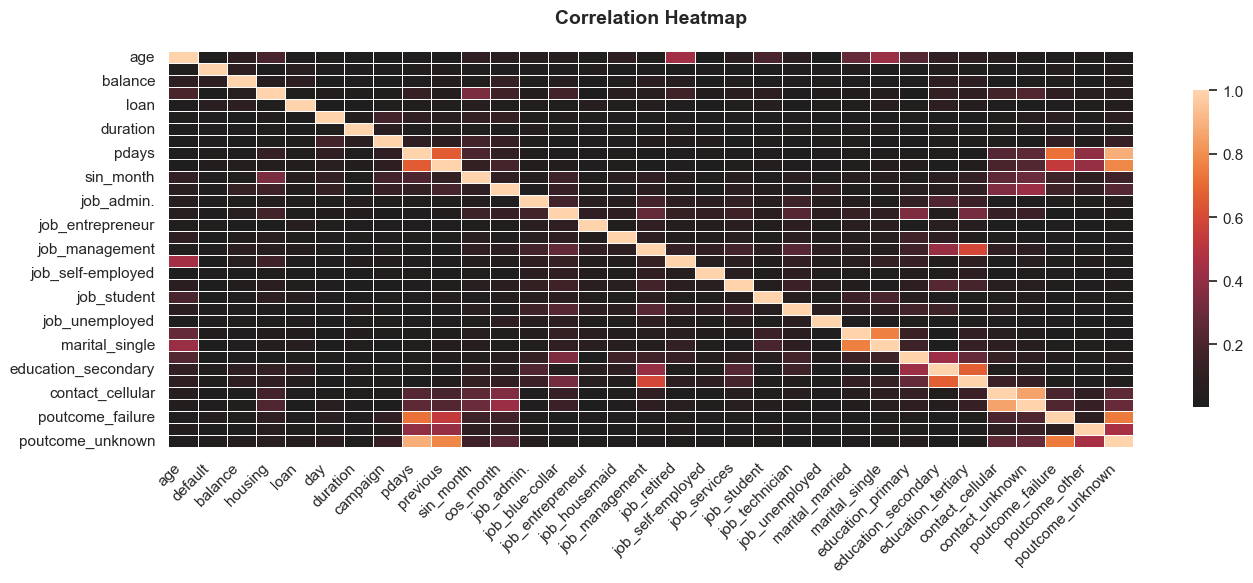

In [41]:
plt.figure(figsize=(14, 6))
corr = data_X_df.corr().abs()

ax = sns.heatmap(
    corr,
    # annot=True,
    # fmt=".2f",              # format correlations
    center=0,               # center at 0 for diverging colormap
    linewidths=0.5,         # grid lines
    cbar_kws={"shrink": .8} # shrink colorbar for readability
)

ax.set_title("Correlation Heatmap", fontsize=14, fontweight="bold", pad=20)
plt.xticks(rotation=45, ha="right")   # rotate x labels
plt.yticks(rotation=0)                # keep y labels horizontal
plt.tight_layout()
plt.show()

## 1.2 Handle Multi Colinearity

In [42]:
X_reduced, dropped_cols = drop_highly_correlated(data_X_df, data_y_df.squeeze(), threshold=0.65)
print(dropped_cols)
X_reduced.shape

pdays ↔ previous | corr=0.663 | drop=pdays
pdays ↔ poutcome_failure | corr=0.722 | drop=poutcome_failure
previous ↔ poutcome_unknown | corr=0.776 | drop=previous
marital_married ↔ marital_single | corr=0.764 | drop=marital_single
education_secondary ↔ education_tertiary | corr=0.666 | drop=education_secondary
contact_cellular ↔ contact_unknown | corr=0.859 | drop=contact_cellular

Columns to drop (6): ['contact_cellular', 'education_secondary', 'marital_single', 'pdays', 'poutcome_failure', 'previous']
['previous', 'pdays', 'marital_single', 'education_secondary', 'contact_cellular', 'poutcome_failure']


(4521, 27)

In [43]:
X_vif_reduced, final_vif_df = drop_high_vif_features(X_reduced, threshold=6.5)



Iteration 1:
Dropping 'age' (VIF = 20.74)

Iteration 2:
Dropping 'poutcome_unknown' (VIF = 7.91)

Iteration 3:

 All VIFs ≤ 6.5. Stopping.


In [44]:
final_vif_df

,feature,VIF
0,default,1.033519
1,balance,1.362931
2,housing,2.859776
3,loan,1.212287
4,day,4.867391
5,duration,2.194176
6,campaign,2.267504
7,sin_month,1.292447
8,cos_month,2.088520
9,job_admin.,2.040719


In [45]:
X_vif_reduced.shape

(4521, 25)

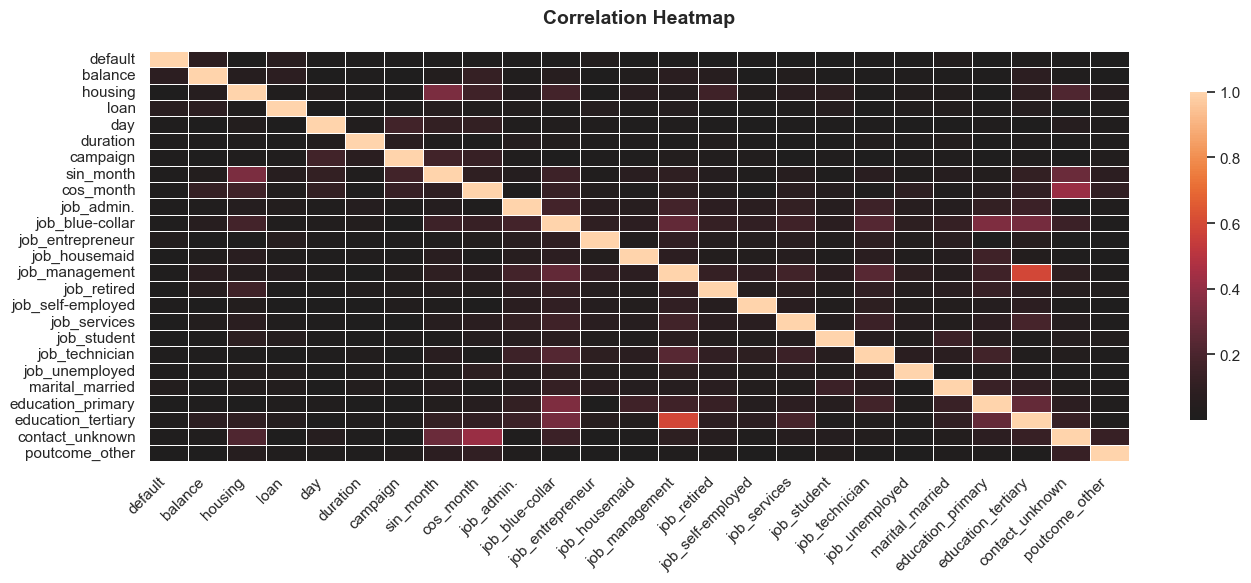

In [46]:
plt.figure(figsize=(14, 6))
corr = X_vif_reduced.corr().abs()

ax = sns.heatmap(
    corr,
    # annot=True,
    # fmt=".2f",              # format correlations
    center=0,               # center at 0 for diverging colormap
    linewidths=0.5,         # grid lines
    cbar_kws={"shrink": .8} # shrink colorbar for readability
)

ax.set_title("Correlation Heatmap", fontsize=14, fontweight="bold", pad=20)
plt.xticks(rotation=45, ha="right")   # rotate x labels
plt.yticks(rotation=0)                # keep y labels horizontal
plt.tight_layout()
plt.show()

# 2. Model Builder

In [47]:
model_builder = KMeansModelBuilder(X_vif_reduced)
model_builder.scale_data()


Data successfully scaled using StandardScaler.


K=2: WCSS=105281.04, Silhouette Score=0.0857
K=3: WCSS=99662.06, Silhouette Score=0.0639
K=4: WCSS=94134.90, Silhouette Score=0.1179
K=5: WCSS=88539.43, Silhouette Score=0.1291
K=6: WCSS=84092.51, Silhouette Score=0.1475
K=7: WCSS=78601.34, Silhouette Score=0.1810
K=8: WCSS=73648.05, Silhouette Score=0.1958
K=9: WCSS=68969.78, Silhouette Score=0.2177
K=10: WCSS=64293.06, Silhouette Score=0.2359
K=11: WCSS=59468.67, Silhouette Score=0.2525
K=12: WCSS=57839.29, Silhouette Score=0.2430
K=13: WCSS=54028.78, Silhouette Score=0.2364
K=14: WCSS=52663.32, Silhouette Score=0.2155
K=15: WCSS=51502.85, Silhouette Score=0.2201
K=16: WCSS=50118.69, Silhouette Score=0.2151
K=17: WCSS=48263.62, Silhouette Score=0.2007
K=18: WCSS=47659.77, Silhouette Score=0.1977
K=19: WCSS=46478.94, Silhouette Score=0.2083
K=20: WCSS=45594.50, Silhouette Score=0.2000

 Optimal K based on silhouette score: 11


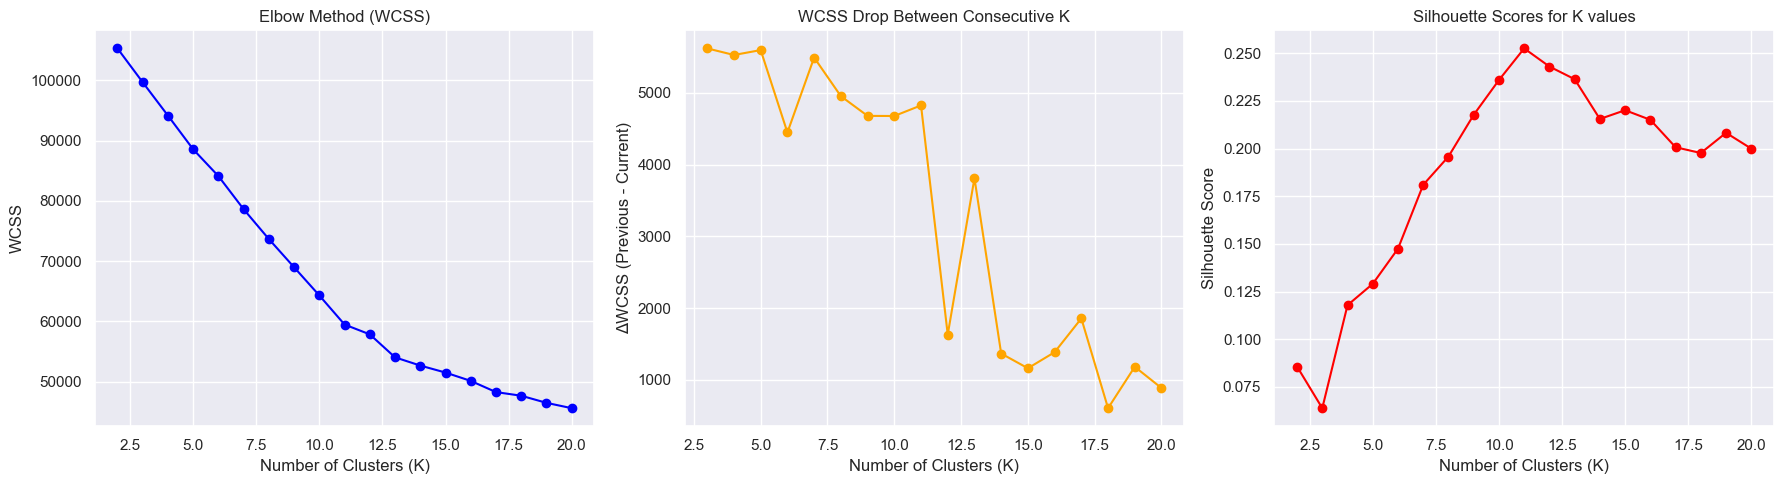

In [48]:
model_builder.evaluate_k_values(20)

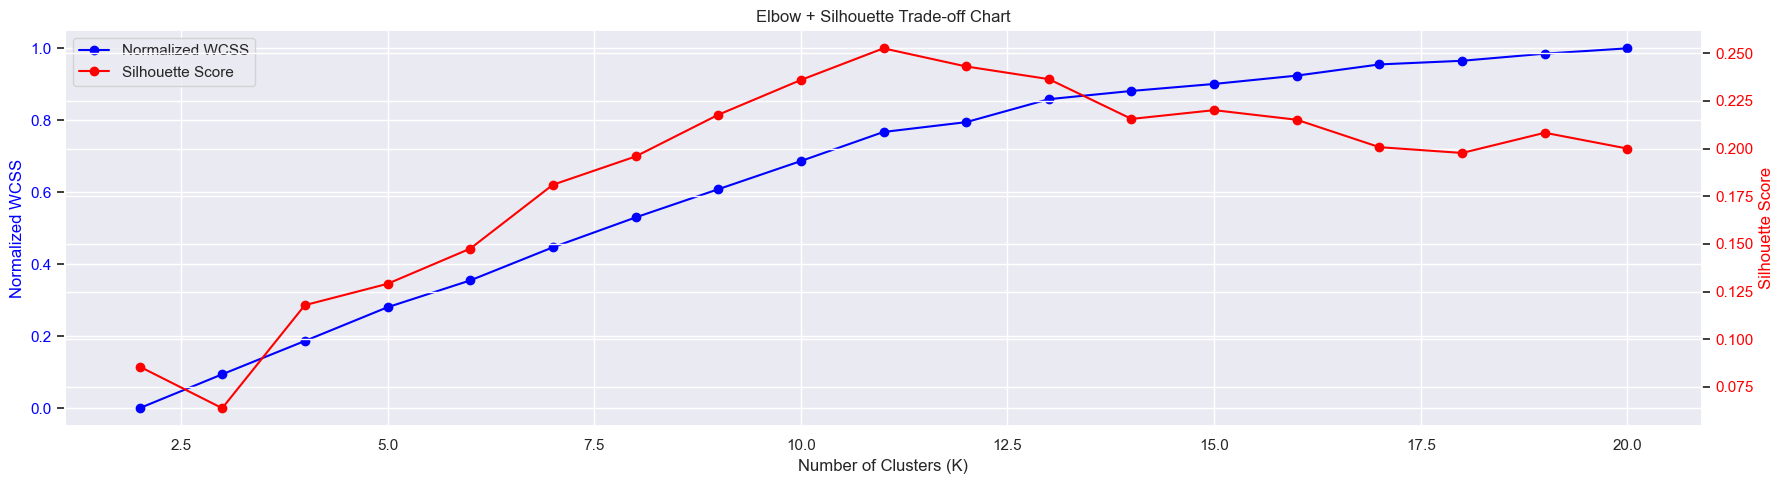

In [49]:
model_builder.plot_elbow_silhouette_tradeoff(20)

In [50]:
labels = model_builder.build_final_model(11)


Final KMeans model built with K=11
Final Silhouette Score: 0.2525


In [52]:
clustered_df = X_vif_reduced.copy(deep = True)
clustered_df = pd.concat(
    [clustered_df, labels_df],
    axis = 1
)
clustered_df = clustered_df.rename(
    columns  = {
        0 : "Cluster"
    }
)

clustered_df["Cluster"].value_counts(normalize = True)
# clustered_df.head()

Cluster
1     0.216103
3     0.212121
4     0.173634
9     0.105729
7     0.092236
0     0.050874
6     0.040478
8     0.037160
2     0.028312
10    0.024773
5     0.018580
Name: proportion, dtype: float64

# 3. Result

In [53]:
scaler = StandardScaler()
X = scaler.fit_transform(clustered_df.drop("Cluster", axis=1))
y = clustered_df.loc[:, "Cluster"]

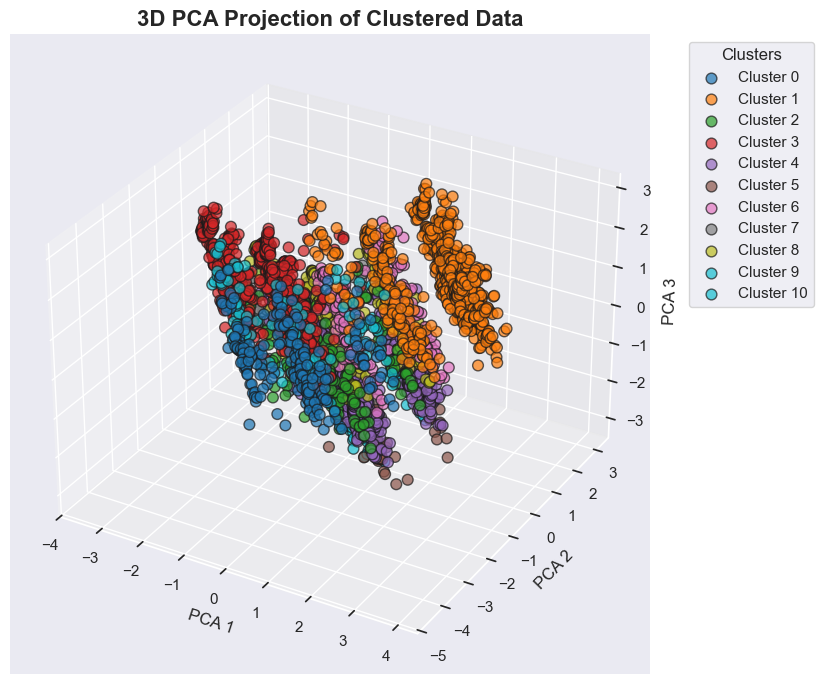

In [54]:
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection="3d")

# Use a discrete colormap and one color per cluster
unique_clusters = np.unique(y)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_clusters)))

for cluster, color in zip(unique_clusters, colors):
    mask = (y == cluster)
    ax.scatter(
        X_pca_3d[mask, 0],
        X_pca_3d[mask, 1],
        X_pca_3d[mask, 2],
        label=f"Cluster {cluster}",
        color=color,
        alpha=0.7,
        s=60,
        edgecolor="k"
    )

ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_zlabel("PCA 3")
ax.set_title("3D PCA Projection of Clustered Data", fontsize=16, weight="bold")

ax.legend(title="Clusters", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# END